In [12]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import box
import geopandas as gpd
from subs import ptsinpoly
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

In [3]:
npfile = np.load(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\theilslopes_DTW.npz')
print(npfile.files)

['dtw_syr', 'dtw_condyr', 'dtw_s_nmax_yr', 'dtw_nmax_yr', 'dtw_vyr', 'dtw_tyr', 'dtw_resyr', 'HydroID', 'lat', 'lon', 'dtw_interc_t', 'dtw_slop_t']


In [4]:
dtw_syr       = npfile.f.dtw_syr
dtw_condyr    = npfile.f.dtw_condyr
dtw_s_nmax_yr = npfile.f.dtw_s_nmax_yr
dtw_nmax_yr   = npfile.f.dtw_nmax_yr
dtw_tyr       = npfile.f.dtw_tyr
dtw_vyr       = npfile.f.dtw_vyr
dtw_resyr     = npfile.f.dtw_resyr
HydroID       = npfile.f.HydroID
lat           = npfile.f.lat
lon           = npfile.f.lon
dtw_interc_t  = npfile.f.dtw_interc_t
dtw_slop_t    = npfile.f.dtw_slop_t

In [5]:
# Límites de Australia (aproximados en latitud y longitud)
min_lat, max_lat = -44, -10
min_lon, max_lon = 112, 154

In [6]:
cell_size = 1.0 ## Se cambia según el tamaño de la grilla que se quiera
umbral_min_puntos = 20  # Mínimo de puntos por celda

# Crear las coordenadas de la grilla
lat_edges = np.arange(min_lat, max_lat + cell_size, cell_size)
lon_edges = np.arange(min_lon, max_lon + cell_size, cell_size)

# Coordenadas centrales de cada celda
lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2

In [7]:
celdas = []
for i in range(len(lat_edges) - 1):
    for j in range(len(lon_edges) - 1):
        celdas.append(Polygon([
            (lon_edges[j], lat_edges[i]),
            (lon_edges[j + 1], lat_edges[i]),
            (lon_edges[j + 1], lat_edges[i + 1]),
            (lon_edges[j], lat_edges[i + 1]),
            (lon_edges[j], lat_edges[i])
        ]))

In [8]:
resultados_grilla = []

for celda in celdas:
    # Extraer los vértices del polígono directamente
    pflat = np.array(celda.exterior.xy[1])  # Latitudes
    pflon = np.array(celda.exterior.xy[0])  # Longitudes

    # Usar ptsinpoly para verificar puntos en la celda
    indices_dentro = ptsinpoly(pflat, pflon, npfile.f.lat, npfile.f.lon)

    # Extraer los puntos dentro de la celda
    dtw_dentro = dtw_slop_t[indices_dentro]

    # Calcular el centroide de la celda para referencia
    center = celda.centroid.coords[0]

    # Almacenar resultados por celda
    resultados_grilla.append({
        'center': center,
        'dtw_slop_t': dtw_dentro
    })

In [9]:
ruta_shapefile = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\australia_aquifers.shp'  
australia = gpd.read_file(ruta_shapefile)

C:\Users\AFANDINOP\AppData\Local\Temp\ipykernel_7156\3150696998.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


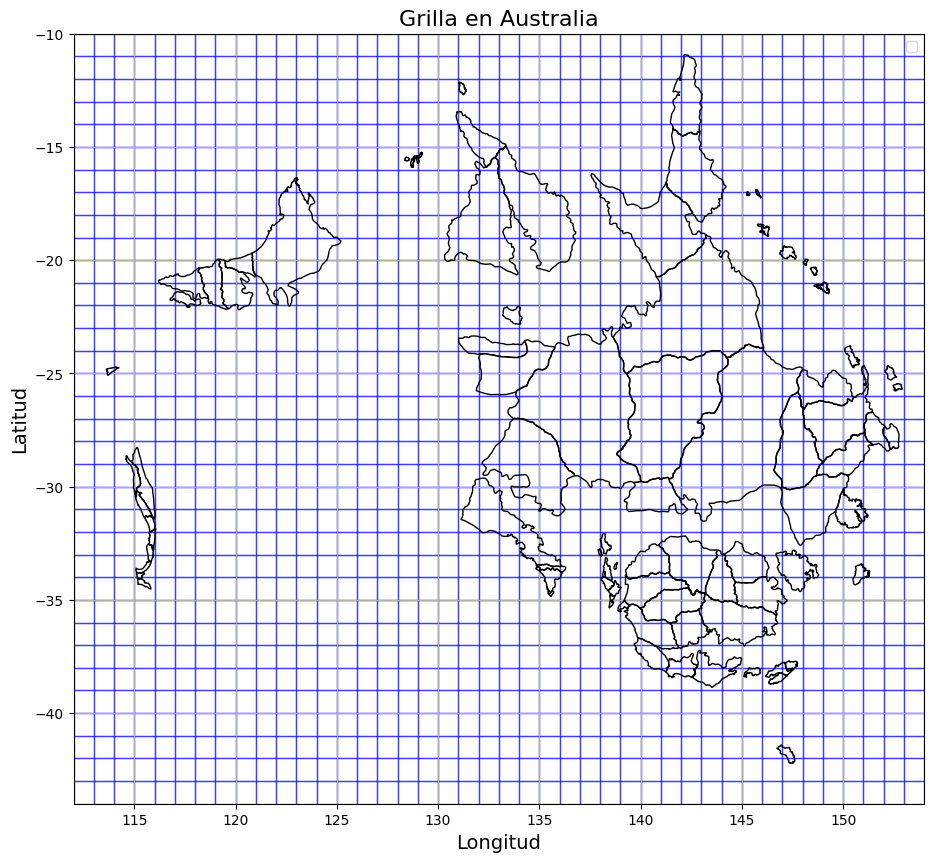

In [39]:
fig, ax = plt.subplots(figsize=(12, 10))

# Dibuja el contorno de Australia
australia.boundary.plot(ax=ax, color='black', linewidth=1)

# Dibuja cada celda en la grilla
for celda in celdas:
    patch = MplPolygon(np.array(celda.exterior.xy).T, edgecolor='blue', facecolor='none', alpha=0.5)
    ax.add_patch(patch)

# Configurar límites y etiquetas
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
ax.set_title('Grilla en Australia', fontsize=16)
ax.set_xlabel('Longitud', fontsize=14)
ax.set_ylabel('Latitud', fontsize=14)
plt.grid(True)
plt.legend()
plt.savefig(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\histogramas\grilla\grilla_1°\grilla_1°.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
output_folder = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\histogramas\grilla\grilla_5°'

for i, r in enumerate(resultados_grilla):
    # Filtrar los datos para que estén entre -0.5 y 0.5
    datos_validos = r['dtw_slop_t'][(r['dtw_slop_t'] >= -0.5) & (r['dtw_slop_t'] <= 0.5)]
    
    # Verificación de los datos filtrados
    if len(datos_validos) < 20:
        # Saltar celdas con menos de 20 datos válidos
        continue

    # Centro de la celda
    lat, lon = r['center']
    
    # Calcular estadísticas
    mean = np.mean(datos_validos)
    median = np.median(datos_validos)
    std_dev = np.std(datos_validos)
    variance = np.var(datos_validos)  
    skewness = skew(datos_validos)  
    kurt = kurtosis(datos_validos)  

    # Crear la figura y el histograma
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.hist(datos_validos, bins=np.arange(-0.5, 0.5, 0.01), color='skyblue', edgecolor='black', alpha=0.7)
    ax1.set_title(f'Histograma - Centro: ({lat:.2f}, {lon:.2f})', fontsize=14)
    ax1.set_xlabel('Pendiente (dtw_slop_t)', fontsize=12)
    ax1.set_ylabel('Frecuencia', fontsize=12)
    ax1.grid(axis='both', linestyle='--', alpha=0.7)
    
    # Línea vertical en cero
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=1)

    # Texto de estadísticas con alineación perfecta
    stats_text = (
        f'{"Media:":<12} {mean:>8.3f}\n'
        f'{"Mediana:":<12} {median:>8.3f}\n'
        f'{"Desv. Est.:":<12} {std_dev:>8.3f}\n'
        f'{"Varianza:":<12} {variance:>8.3f}\n'
        f'{"Sesgo:":<12} {skewness:>8.3f}\n'
        f'{"Curtosis:":<12} {kurt:>8.3f}'
    )

    # Posición del texto (esquina superior derecha)
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.8), 
             fontfamily='monospace')  # Usar fuente monoespaciada para mejor alineación

    # Guardar el histograma
    output_path = os.path.join(output_folder, f"Celda_{lat:.2f}_{lon:.2f}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

In [40]:
# Configuración de rutas
output_npz = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\histogramas\estadisticas_grilla1.npz'

# Listas para almacenar todas las estadísticas
centros_lat   = []
centros_lon   = []
medias        = []
medianas      = []
desviaciones  = []
varianzas     = []
sesgos        = []
curtosis_list = []
conteos       = []

for i, r in enumerate(resultados_grilla):
    try:
        # Filtrar datos como lo haces actualmente
        datos_validos = r['dtw_slop_t'][(r['dtw_slop_t'] >= -0.5) & (r['dtw_slop_t'] <= 0.5)]
        
        # Saltar celdas con pocos datos
        if len(datos_validos) < 20:
            continue

        # Obtener coordenadas del centro
        lat, lon = r['center']
        
        # Calcular estadísticas (con protección contra NaN/Inf)
        centros_lat.append(float(lat))
        centros_lon.append(float(lon))
        medias.append(float(np.nanmean(datos_validos)))
        medianas.append(float(np.nanmedian(datos_validos)))
        desviaciones.append(float(np.nanstd(datos_validos)))
        varianzas.append(float(np.nanvar(datos_validos)))
        sesgos.append(float(skew(datos_validos, nan_policy='omit')))
        curtosis_list.append(float(kurtosis(datos_validos, nan_policy='omit')))
        conteos.append(int(len(datos_validos)))
        
        # Mostrar progreso
        if i % 100 == 0:
            print(f"Procesadas {i}/{len(resultados_grilla)} celdas...")
            
    except Exception as e:
        print(f"Error en celda {i}: {str(e)}")
        continue

# Convertir a arrays numpy
centros_lat   = np.array(centros_lat)
centros_lon   = np.array(centros_lon)
medias        = np.array(medias)
medianas      = np.array(medianas)
desviaciones  = np.array(desviaciones)
varianzas     = np.array(varianzas)
sesgos        = np.array(sesgos)
curtosis_list = np.array(curtosis_list)
conteos       = np.array(conteos)

# Guardar en archivo NPZ
np.savez(
    output_npz,
    centros_lat=centros_lat,
    centros_lon=centros_lon,
    medias=medias,
    medianas=medianas,
    desviaciones=desviaciones,
    varianzas=varianzas,
    sesgos=sesgos,
    curtosis=curtosis_list,
    conteos=conteos
)

print(f"\nDatos guardados exitosamente en: {output_npz}")
print(f"Resumen: {len(centros_lat)} celdas procesadas")
print(f"Rango de curtosis: {np.min(curtosis_list):.2f} a {np.max(curtosis_list):.2f}")


Datos guardados exitosamente en: G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\histogramas\estadisticas_grilla1.npz
Resumen: 94 celdas procesadas
Rango de curtosis: -1.19 a 29.91


### Percentiles

In [70]:
output_folder = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\histogramas\percentiles\grilla\grilla_1°'
os.makedirs(output_folder, exist_ok=True)

for i, r in enumerate(resultados_grilla):
    # Filtrar datos entre -0.5 y 0.5
    datos_validos = r['dtw_slop_t'][(r['dtw_slop_t'] >= -0.5) & (r['dtw_slop_t'] <= 0.5)]
    
    # Saltar celdas con menos de 20 datos
    if len(datos_validos) < 20:
        continue

    lat, lon = r['center']
    
    # --- Calcular PERCENTILES ---
    percentiles = {
        'P25': np.percentile(datos_validos, 25),
        'P40': np.percentile(datos_validos, 40),
        'P50': np.percentile(datos_validos, 50),  # Equivale a la mediana
        'P60': np.percentile(datos_validos, 60),
        'P75': np.percentile(datos_validos, 75)
    }

    # --- Configurar gráfico ---
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Histograma
    ax.hist(datos_validos, bins=np.arange(-0.5, 0.5, 0.01), 
            color='skyblue', edgecolor='black', alpha=0.7)
    
    # Líneas de referencia
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1, label='Cero')
    
    # Líneas para percentiles (colores distintos)
    colors = ['green', 'purple', 'orange', 'brown', 'blue']
    for (name, value), color in zip(percentiles.items(), colors):
        ax.axvline(x=value, color=color, linestyle=':', 
                  linewidth=1.5, alpha=0.8, label=f'{name} = {value:.3f}')

    # --- Ajustes del gráfico ---
    ax.set_title(f'Distribución de Pendientes - Celda ({lat:.2f}, {lon:.2f})', fontsize=14)
    ax.set_xlabel('Pendiente (dtw_slop_t)', fontsize=12)
    ax.set_ylabel('Frecuencia', fontsize=12)
    ax.grid(axis='both', linestyle='--', alpha=0.7)
    
    # --- Texto de PERCENTILES (esquina superior derecha) ---
    percentiles_text = (
        f'{"Percentiles":^20}\n\n'
        f'{"P25:":<8} {percentiles["P25"]:>8.3f}\n'
        f'{"P40:":<8} {percentiles["P40"]:>8.3f}\n'
        f'{"P50:":<8} {percentiles["P50"]:>8.3f}\n'
        f'{"P60:":<8} {percentiles["P60"]:>8.3f}\n'
        f'{"P75:":<8} {percentiles["P75"]:>8.3f}'
    )
    
    ax.text(0.95, 0.95, percentiles_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.8),
            fontfamily='monospace')

    # Leyenda unificada
    ax.legend(loc='upper left', fontsize=8)

    # Guardar
    output_path = os.path.join(output_folder, f"Celda_{lat:.2f}_{lon:.2f}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

Guardando mapa en: G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\mapa_australia_final.png
✅ Mapa guardado correctamente en: G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\mapa_australia_final.png


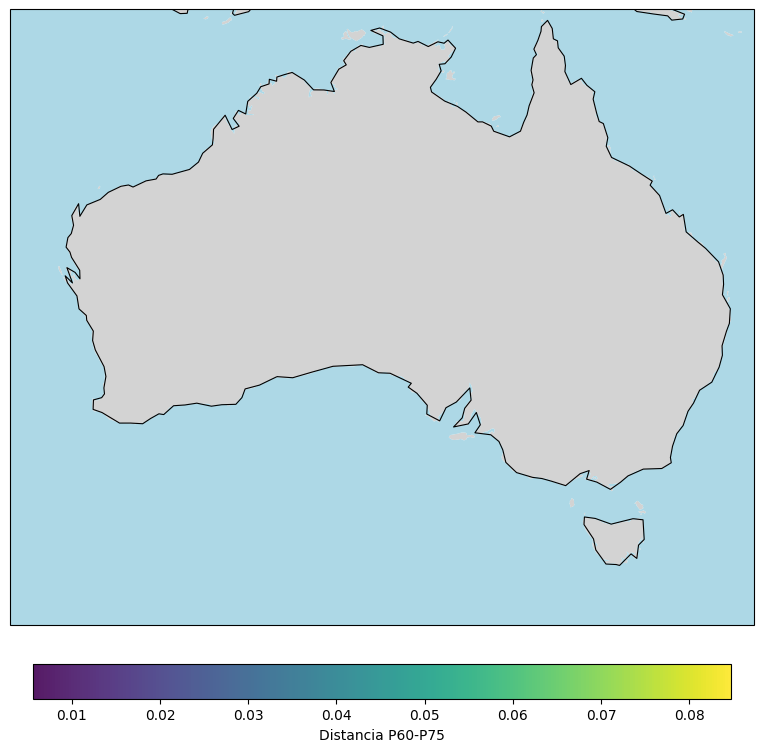

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# --- 1. Configuración inicial ---
# Usar una ruta absoluta válida para guardar el mapa
output_path = os.path.abspath('mapa_australia_final.png')  # Esto evitará el error de guardado
print(f"Guardando mapa en: {output_path}")

# --- 2. Crear figura y ejes ---
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# --- 3. Configurar límites para Australia ---
ax.set_extent([110, 155, -45, -10])  # Ajustado a tus datos

# --- 4. Añadir características base ---
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.coastlines(resolution='110m', linewidth=0.8)

# --- 5. Graficar puntos (con verificación) ---
if not df_distancias.empty:
    # Verificar columnas necesarias
    required_columns = ['lon', 'lat', 'dist_P60_P75']
    if all(col in df_distancias.columns for col in required_columns):
        sc = ax.scatter(
            df_distancias['lon'],
            df_distancias['lat'],
            c=df_distancias['dist_P60_P75'],
            cmap='viridis',
            s=100,
            alpha=0.9,
            transform=ccrs.PlateCarree(),
            vmin=df_distancias['dist_P60_P75'].quantile(0.05),  # Ajuste automático
            vmax=df_distancias['dist_P60_P75'].quantile(0.95)
        )
        
        # Barra de color
        cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.05, shrink=0.6)
        cbar.set_label('Distancia P60-P75')
    else:
        print("⚠️ Faltan columnas necesarias en los datos")
else:
    print("⚠️ El DataFrame está vacío")

# --- 6. Guardar y mostrar ---
try:
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ Mapa guardado correctamente en: {output_path}")
except Exception as e:
    print(f"❌ Error al guardar: {e}")

plt.show()  # Muestra el mapa en una ventana emergente para verificar

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Configuración inicial ---
output_folder = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\mapas'
os.makedirs(output_folder, exist_ok=True)

# --- Paso 1: Limpieza rigurosa de datos ---
df_clean = df_distancias.copy()

# Eliminar filas con NaN o Inf en coordenadas o valores clave
cols_to_check = ['lat', 'lon', 'dist_P60_P75']
df_clean = df_clean[
    df_clean[cols_to_check].notnull().all(axis=1) & 
    np.isfinite(df_clean[cols_to_check]).all(axis=1)
]

if df_clean.empty:
    raise ValueError("❌ Todos los datos fueron descartados por contener NaN/Inf.")

# --- Paso 2: Clasificación en quintiles (con validación) ---
try:
    df_clean['dist_group'] = pd.qcut(
        df_clean['dist_P60_P75'],
        q=5,
        labels=False,
        duplicates='drop'
    )
except Exception as e:
    print(f"⚠️ Error en quintiles: {e}. Usando división lineal...")
    df_clean['dist_group'] = pd.cut(
        df_clean['dist_P60_P75'],
        bins=5,
        labels=False
    )

# --- Paso 3: Validación de límites del mapa ---
lat_min, lat_max = df_clean['lat'].min(), df_clean['lat'].max()
lon_min, lon_max = df_clean['lon'].min(), df_clean['lon'].max()

# Añadir margen seguro (evitar límites infinitos)
buffer = 1.0  # Grados de margen
ax_extent = [
    max(lon_min - buffer, -180),  # No menor que -180
    min(lon_max + buffer, 180),   # No mayor que 180
    max(lat_min - buffer, -90),   # No menor que -90
    min(lat_max + buffer, 90)     # No mayor que 90
]

# --- Paso 4: Crear el mapa ---
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(ax_extent, crs=ccrs.PlateCarree())

# Capas base (sin dependencias externas)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.coastlines(resolution='110m', linewidth=0.8)

# Graficar puntos
sc = ax.scatter(
    df_clean['lon'],
    df_clean['lat'],
    c=df_clean['dist_group'],
    cmap='viridis',
    s=100,
    transform=ccrs.PlateCarree(),
    vmin=0,
    vmax=4
)

# Barra de color y título
plt.colorbar(sc, ax=ax, label='Quintiles de Distancia P60-P75')
plt.title('Distribución de Distancias P60-P75')

# Guardar
plt.savefig(os.path.join(output_folder, 'mapa_final.png'), dpi=300, bbox_inches='tight')
plt.close()

print("✅ Mapa generado con éxito.")

In [20]:
print("🔍 Valores problemáticos en coordenadas:")
print(df_distancias[['lat', 'lon']].describe())
print("\nValores infinitos o NaN:")
print(df_distancias[['lat', 'lon']].isnull().sum())

🔍 Valores problemáticos en coordenadas:
              lat        lon
count   94.000000  94.000000
mean   141.010638 -31.117021
std     10.228302   6.530501
min    113.500000 -38.500000
25%    138.500000 -35.500000
50%    144.000000 -33.500000
75%    147.500000 -27.750000
max    152.500000 -12.500000

Valores infinitos o NaN:
lat    0
lon    0
dtype: int64


#### "Mejorada 4x4"

In [13]:
# Configuración inicial
output_folder = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\histogramas\grilla\grilla_4°\mejor'
os.makedirs(output_folder, exist_ok=True)

for i, r in enumerate(resultados_grilla):
    # Filtrar datos válidos (-0.5 a 0.5)
    datos_validos = r['dtw_slop_t'][(r['dtw_slop_t'] >= -0.5) & (r['dtw_slop_t'] <= 0.5)]
    
    # Saltar celdas con menos de 20 datos (ya validaste que el 90% cumplen)
    if len(datos_validos) < 20:
        continue

    lat, lon = r['center']
    
    # --- Calcular percentiles ---
    percentiles = {
        'P25': np.percentile(datos_validos, 25),
        'P40': np.percentile(datos_validos, 40),
        'P50': np.percentile(datos_validos, 50),
        'P60': np.percentile(datos_validos, 60),
        'P75': np.percentile(datos_validos, 75)
    }

    # --- Crear figura con dos subplots ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 1]})
    
    # --- Subplot 1: Histograma + KDE ---
    sns.histplot(datos_validos, bins='fd', kde=True, ax=ax1, color='skyblue', edgecolor='black', alpha=0.7)
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=1, label='Cero')
    
    # Añadir líneas de percentiles
    colors = ['green', 'purple', 'orange', 'brown', 'blue']
    for (name, value), color in zip(percentiles.items(), colors):
        ax1.axvline(x=value, color=color, linestyle=':', linewidth=1.5, label=f'{name} = {value:.3f}')
    
    ax1.set_title(f'Distribución de Pendientes\nCelda: ({lat:.2f}, {lon:.2f})', fontsize=14)
    ax1.set_xlabel('Pendiente (dtw_slop_t)', fontsize=12)
    ax1.set_ylabel('Densidad', fontsize=12)
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(axis='both', linestyle='--', alpha=0.7)

    # --- Subplot 2: Boxplot ---
    ax2.boxplot(datos_validos, vert=False, patch_artist=True, 
                boxprops=dict(facecolor='lightgreen', color='black'),
                medianprops=dict(color='red'))
    ax2.set_title('Resumen Estadístico', fontsize=14)
    ax2.set_xlabel('Pendiente (dtw_slop_t)', fontsize=12)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    # --- Ajustes finales ---
    plt.tight_layout()
    
    # Guardar figura
    output_path = os.path.join(output_folder, f"Celda_{lat:.2f}_{lon:.2f}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

print("Proceso completado. Grilla 4°x4° generada con éxito.")

Proceso completado. Grilla 4°x4° generada con éxito.


#### Imágenes resultados (grilla)

Gráfico guardado en: G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\histogramas\resultados\grilla_1°_histogramas.png


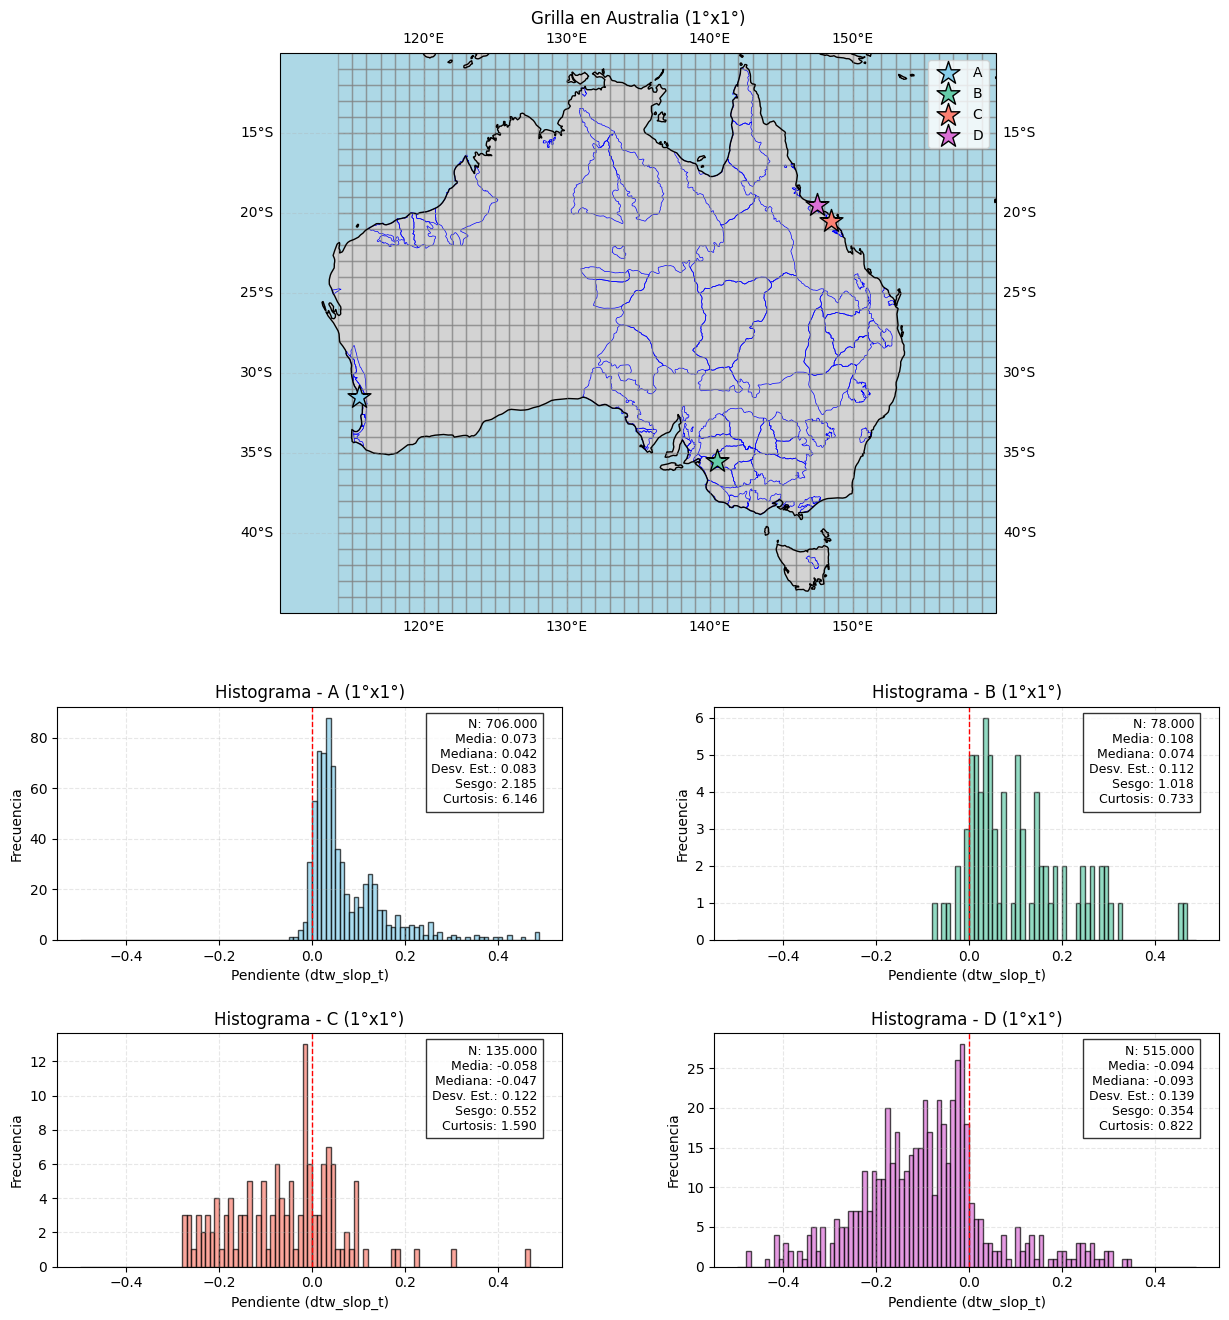

In [69]:
tamano_grilla = 1

# 2. Cargar shapefile
try:
    shp_path = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\australia_aquifers.shp'
    data = gpd.read_file(shp_path)
    
    if data.empty:
        raise ValueError("El shapefile está vacío")
    
    if 'Broader' in data.columns:
        australia = data[data['Broader'].isna()].dissolve()
        cuencas = data[data['Broader'].notna()]
    else:
        australia = data.dissolve()
        cuencas = gpd.GeoDataFrame()
    
except Exception as e:
    print(f"Error cargando shapefile: {e}")
    exit()

# 3. Datos de ubicaciones
ubicaciones = [
    {"nombre": "A", "coords": (115.5, -31.5), "color": "skyblue"},
    {"nombre": "B", "coords": (140.5, -35.5), "color": "mediumaquamarine"},
    {"nombre": "C", "coords": (148.5, -20.5), "color": "salmon"},
    {"nombre": "D", "coords": (147.5, -19.5), "color": "orchid"}
]

# 4. Crear figura
fig = plt.figure(figsize=(15, 20))
grid = plt.GridSpec(5, 2, figure=fig, hspace=0.4, wspace=0.3)

# 5. Mapa principal con Cartopy
ax_map = fig.add_subplot(grid[0:2, :], projection=ccrs.PlateCarree())
ax_map.set_extent([110, 160, -45, -10], crs=ccrs.PlateCarree())

# Agregar características base
ax_map.add_feature(cfeature.OCEAN, color='lightblue')
ax_map.add_feature(cfeature.LAND, color='lightgray')
ax_map.add_feature(cfeature.COASTLINE, linewidth=1)
ax_map.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)

# Dibujar shapefiles
try:
    if not australia.empty:
        australia.plot(ax=ax_map, facecolor='none', edgecolor='black', 
                      linewidth=1, transform=ccrs.PlateCarree())
    if not cuencas.empty:
        cuencas.plot(ax=ax_map, facecolor='none', edgecolor='blue', 
                    linewidth=0.5, transform=ccrs.PlateCarree())
except Exception as e:
    print(f"Error dibujando shapefiles: {e}")

# Dibujar grilla
glon = np.linspace(114, 160, int((160-114)/tamano_grilla)+1)
glat = np.linspace(-45, -10, int((-10-(-45))/tamano_grilla)+1)

for i in range(len(glon)-1):
    for j in range(len(glat)-1):
        rect = plt.Rectangle((glon[i], glat[j]), glon[i+1]-glon[i], glat[j+1]-glat[j],
                           fill=False, edgecolor='gray', alpha=0.5, transform=ccrs.PlateCarree())
        ax_map.add_patch(rect)

# Marcadores de ubicaciones
for ubic in ubicaciones:
    ax_map.scatter(*ubic["coords"], s=300, marker='*', color=ubic["color"],
                 edgecolor='black', linewidth=1, label=ubic["nombre"], zorder=10,
                 transform=ccrs.PlateCarree())

ax_map.set_title(f'Grilla en Australia ({tamano_grilla}°x{tamano_grilla}°)')
ax_map.legend(loc='upper right')
ax_map.gridlines(draw_labels=True, linestyle='--', alpha=0.3)

# 6. Histogramas - Versión adaptada a tu estructura de datos
for i, ubic in enumerate(ubicaciones):
    ax_hist = fig.add_subplot(grid[2 + i//2, i%2])
    
    # 1. ENCONTRAR LA CELDA CORRECTA - VERSIÓN ADAPTADA
    celda_encontrada = None
    for celda in resultados_grilla:
        # Asumiendo que cada celda tiene 'center' con (lon, lat)
        lon_center, lat_center = celda['center']
        if (lon_center - tamano_grilla/2 <= ubic["coords"][0] <= lon_center + tamano_grilla/2 and
            lat_center - tamano_grilla/2 <= ubic["coords"][1] <= lat_center + tamano_grilla/2):
            celda_encontrada = celda
            break
    
    if celda_encontrada is None:
        print(f"No se encontró celda para {ubic['nombre']}")
        ax_hist.text(0.5, 0.5, 'Datos no disponibles', ha='center', va='center')
        continue
    
    # 2. OBTENER Y FILTRAR DATOS
    try:
        # Asumiendo que los datos están en 'dtw_slop_t'
        datos_celda = np.array(celda_encontrada['dtw_slop_t'])
        datos_validos = datos_celda[~np.isnan(datos_celda) & 
                                  (datos_celda >= -0.5) & 
                                  (datos_celda <= 0.5)]
    except KeyError:
        print(f"No se encontraron datos de pendiente para {ubic['nombre']}")
        ax_hist.text(0.5, 0.5, 'Datos faltantes', ha='center', va='center')
        continue
    
    if len(datos_validos) == 0:
        print(f"No hay datos válidos para {ubic['nombre']}")
        ax_hist.text(0.5, 0.5, 'Sin datos válidos', ha='center', va='center')
        continue
    
    # 3. CREAR HISTOGRAMA
    ax_hist.hist(datos_validos, bins=np.arange(-0.5, 0.5, 0.01),
                color=ubic["color"], edgecolor='black', alpha=0.7)
    ax_hist.axvline(x=0, color='red', linestyle='--', linewidth=1)
    
    # 4. CALCULAR ESTADÍSTICAS (con protección para pocos datos)
    stats = {'N': len(datos_validos)}
    
    if len(datos_validos) > 0:
        stats.update({
            'Media': np.mean(datos_validos),
            'Mediana': np.median(datos_validos)
        })
    if len(datos_validos) > 1:
        stats['Desv. Est.'] = np.std(datos_validos)
    if len(datos_validos) > 2:
        stats['Sesgo'] = skew(datos_validos)
    if len(datos_validos) > 3:
        stats['Curtosis'] = kurtosis(datos_validos)
    
    # 5. MOSTRAR ESTADÍSTICAS
    stats_text = '\n'.join([f'{k}: {v:.3f}' if isinstance(v, (float, int)) else f'{k}: {v}' 
                   for k, v in stats.items()])
    ax_hist.text(0.95, 0.95, stats_text, transform=ax_hist.transAxes,
                fontsize=9, verticalalignment='top', horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.8))
    
    ax_hist.set(title=f'Histograma - {ubic["nombre"]} ({tamano_grilla}°x{tamano_grilla}°)',
               xlabel='Pendiente (dtw_slop_t)', ylabel='Frecuencia')
    ax_hist.grid(True, linestyle='--', alpha=0.3)

# 7. Guardar
output_dir = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\histogramas\resultados'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f'grilla_{tamano_grilla}°_histogramas.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Gráfico guardado en: {output_path}")
plt.show()